# EfficientNet building for DF2

### Connecting to DF2

In [ ]:
import boto3
import os
import pandas as pd
import json
import matplotlib.image as img
from PIL import Image


In [1]:
# Setting up connection to DF2 bucket
bucket = 'descriptiveworld-datasets'
subfolder = 'DeepFashion2/'

In [2]:
from sagemaker import get_execution_role
role = get_execution_role()

In [3]:
conn = boto3.client('s3')
contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
for f in contents:
    print(f['Key'])

DeepFashion2/
DeepFashion2/test/image/000001.jpg
DeepFashion2/test/image/000002.jpg
DeepFashion2/test/image/000003.jpg
DeepFashion2/test/image/000004.jpg
DeepFashion2/test/image/000005.jpg
DeepFashion2/test/image/000006.jpg
DeepFashion2/test/image/000007.jpg
DeepFashion2/test/image/000008.jpg
DeepFashion2/test/image/000009.jpg
DeepFashion2/test/image/000010.jpg
DeepFashion2/test/image/000011.jpg
DeepFashion2/test/image/000012.jpg
DeepFashion2/test/image/000013.jpg
DeepFashion2/test/image/000014.jpg
DeepFashion2/test/image/000015.jpg
DeepFashion2/test/image/000016.jpg
DeepFashion2/test/image/000017.jpg
DeepFashion2/test/image/000018.jpg
DeepFashion2/test/image/000019.jpg
DeepFashion2/test/image/000020.jpg
DeepFashion2/test/image/000021.jpg
DeepFashion2/test/image/000022.jpg
DeepFashion2/test/image/000023.jpg
DeepFashion2/test/image/000024.jpg
DeepFashion2/test/image/000025.jpg
DeepFashion2/test/image/000026.jpg
DeepFashion2/test/image/000027.jpg
DeepFashion2/test/image/000028.jpg
DeepFa

### Importing json for training set

In [4]:
os.getcwd()

'/home/ec2-user/SageMaker'

In [9]:
# orig_file = 'DeepFashion2/train/train.json'
# dest_file = '/home/ec2-user/SageMaker/train.json'

# # Connect to S3 bucket and download file - train.json
# s3 = boto3.resource('s3')
# s3.Bucket(bucket).download_file(orig_file, dest_file)

In [5]:
# Reading in json
train_df = pd.read_json("train.json")

In [6]:
train_df.head()

,item2,source,pair_id,item3,item4,item6,item5,item8,item7,img,segmentation,scale,viewpoint,zoom_in,landmarks,style,bounding_box,category_id,occlusion,category_name
0,"{'segmentation': [[460, 438, 374, 484, 251, 52...",user,1,None,None,None,None,None,None,000001.jpg,"[[257, 35, 261, 89, 228, 123, 137, 103, 45, 91...",3,2,2,"[182, 54, 1, 45, 91, 1, 137, 103, 1, 228, 123,...",1,"[0, 29, 466, 622]",1,2,short sleeve top
1,"{'segmentation': [[220.25, 187.55, 259.6, 177....",shop,1,None,None,None,None,None,None,000002.jpg,"[[145.21, 314.0, 162.67, 312.8, 175.12, 313.05...",3,2,2,"[127, 335, 1, 73, 340, 1, 107, 354, 1, 140, 35...",1,"[1, 300, 367, 701]",1,2,short sleeve top
2,None,user,2,None,None,None,None,None,None,000003.jpg,"[[338, 64, 299, 133, 228, 189, 183, 121, 160, ...",3,1,2,"[240, 108, 2, 160, 63, 2, 183, 121, 2, 228, 18...",1,"[1, 52, 467, 831]",11,1,long sleeve dress
3,None,user,2,None,None,None,None,None,None,000004.jpg,"[[266, 160, 257, 191, 233, 218, 184, 210, 149,...",3,2,2,"[223, 187, 1, 149, 190, 2, 184, 210, 2, 233, 2...",1,"[0, 113, 467, 623]",11,1,long sleeve dress
4,None,user,2,None,None,None,None,None,None,000005.jpg,"[[204.0, 143.0, 182.0, 137.0, 167.0, 130.0, 16...",3,1,2,"[205, 143, 2, 162, 129, 2, 192, 164, 2, 222, 1...",1,"[1, 98, 467, 814]",11,1,long sleeve dress


In [7]:
# Making a subset of the dataframe for testing
train_columns = ['img', 'category_name']
train_sub = train_df.loc[:, train_columns]
train_sub.head()

,img,category_name
0,000001.jpg,short sleeve top
1,000002.jpg,short sleeve top
2,000003.jpg,long sleeve dress
3,000004.jpg,long sleeve dress
4,000005.jpg,long sleeve dress


In [8]:
# Testing only a handfull of labels
short_list = ['short sleeve top', 'trousers', 'long sleeve top', 'short sleeve dress']
train_short = train_sub[train_sub.category_name.isin(short_list)]
train_short.groupby('category_name').count()['img']

category_name
long sleeve top       25085
short sleeve dress    16706
short sleeve top      53914
trousers              23250
Name: img, dtype: int64

### Preparing training images by making folders on local drive

In [10]:
if not os.path.exists('df2'):
    os.mkdir('df2')
if not os.path.exists('df2/train'):
    os.mkdir('df2/train')
if not os.path.exists('df2/val'):
    os.mkdir('df2/val')

In [11]:
train_short_sub = train_short.groupby('category_name').sample(n=5000, random_state=5)
train_short_sub.groupby('category_name').count()

,img
category_name,
long sleeve top,5000
short sleeve dress,5000
short sleeve top,5000
trousers,5000


In [12]:
train_short_sub.head()

,img,category_name
22276,022277.jpg,long sleeve top
7026,007027.jpg,long sleeve top
102933,102935.jpg,long sleeve top
23657,023658.jpg,long sleeve top
149394,149403.jpg,long sleeve top


In [13]:
train_list = list(train_short_sub['img'])
train_list[:5]

['022277.jpg', '007027.jpg', '102935.jpg', '023658.jpg', '149403.jpg']

In [14]:
# # transferring images from s3 to local
# s3 = boto3.resource('s3')

# for image in train_list:
#     orig_img = 'DeepFashion2/train/image/' + image
#     dest_img = '/home/ec2-user/SageMaker/df2/train/' + image
    
#     # Connect to S3 bucket and download image
#     s3.Bucket(bucket).download_file(orig_img, dest_img)

In [15]:
temp_list = os.listdir('./df2/train')
print(len(temp_list))

20000


In [16]:
image = img.imread('/home/ec2-user/SageMaker/df2/train/022277.jpg')
print(image.shape)

(621, 687, 3)


### Setting up dataset for training

In [17]:
# determine the dimensions of each image
# this is necessary for YOLOv5 training, where we have to specify a "longest" dimension for the training
dims = []
for file in list(train_short_sub['img']):
    i = Image.open('./df2/train/'+file)
    dims.append([*i.size])
dims_df = pd.DataFrame(dims, columns=['i_w', 'i_h'])

In [18]:
most_common_w = dims_df.groupby('i_w').count().sort_values(by='i_h', ascending=False).iloc[:1]
most_common_h = dims_df.groupby('i_h').count().sort_values(by='i_w', ascending=False).iloc[:1]
print(most_common_w)
print(most_common_h)

      i_h
i_w      
468  7471
      i_w
i_h      
624  2697


In [19]:
train_short_sub = pd.concat([train_short_sub.reset_index(drop=True), dims_df.reset_index(drop=True)], axis=1)

In [20]:
IMG_DIM = 300

In [21]:
# determine which images are outside the range of the image dim
toosmall = train_short_sub[(train_short_sub['i_w'] < IMG_DIM) | (train_short_sub['i_h'] < IMG_DIM)]
print(len(toosmall))

373


In [22]:
# Removing small images
train_short_sub = train_short_sub[~train_short_sub.img.isin(toosmall.img)]
train_short_sub.head()

,img,category_name,i_w,i_h
0,022277.jpg,long sleeve top,687,621
1,007027.jpg,long sleeve top,750,1125
2,102935.jpg,long sleeve top,750,500
3,023658.jpg,long sleeve top,468,832
5,138296.jpg,long sleeve top,468,624


In [23]:
train_short_sub.groupby('category_name').count()['img']

category_name
long sleeve top       4907
short sleeve dress    4851
short sleeve top      4906
trousers              4963
Name: img, dtype: int64

In [24]:
# Making all remaining class images the same length
train_test = train_short_sub.groupby('category_name').sample(n=3000, random_state=5)
train_test.head()

,img,category_name,i_w,i_h
3040,092400.jpg,long sleeve top,750,1125
3608,142068.jpg,long sleeve top,424,756
513,128992.jpg,long sleeve top,750,588
2595,121091.jpg,long sleeve top,640,640
4743,170517.jpg,long sleeve top,468,624


In [25]:
longST = list(train_test[train_test.category_name == "long sleeve top"]["img"])
shortST = list(train_test[train_test.category_name == "short sleeve top"]["img"])
shortD = list(train_test[train_test.category_name == "short sleeve dress"]["img"])
trousers = list(train_test[train_test.category_name == "trousers"]["img"])

In [26]:
# Making sub_directories for each label
if not os.path.exists('df2/train/long sleeve top'):
    os.mkdir('df2/train/long sleeve top')
if not os.path.exists('df2/train/short sleeve top'):
    os.mkdir('df2/train/short sleeve top')
if not os.path.exists('df2/train/short sleeve dress'):
    os.mkdir('df2/train/short sleeve dress')
if not os.path.exists('df2/train/trousers'):
    os.mkdir('df2/train/trousers')

In [27]:
source_dir = "/home/ec2-user/SageMaker/df2/train/"


for i in short_list:
    dest_dir = "/home/ec2-user/SageMaker/df2/train/" + i + "/"
    
    if i == 'short sleeve top':
        file_list = shortST
    elif i == "long sleeve top":
        file_list = longST
    elif i == "short sleeve dress":
        file_list = shortD
    elif i == 'trousers':
        file_list = trousers
    
    for file in file_list:
        os.rename(source_dir + file, dest_dir + file)

In [30]:
train_test_lab = train_test.loc[:, ['img', 'category_name']]

In [31]:
train_test_lab.head()

,img,category_name
3040,092400.jpg,long sleeve top
3608,142068.jpg,long sleeve top
513,128992.jpg,long sleeve top
2595,121091.jpg,long sleeve top
4743,170517.jpg,long sleeve top


In [32]:
train_test_lab.to_json("/home/ec2-user/SageMaker/test_train.json")

### Preparing validation data

In [45]:
# orig_file = 'DeepFashion2/validation/validation.json'
# dest_file = '/home/ec2-user/SageMaker/validation.json'

# # Connect to S3 bucket and download file - train.json
# s3 = boto3.resource('s3')
# s3.Bucket(bucket).download_file(orig_file, dest_file)

In [46]:
# Reading in json
val_df = pd.read_json("validation.json")

In [47]:
val_sub = val_df.loc[:, train_columns]
val_sub.head()

,img,category_name
0,000001.jpg,vest
1,000002.jpg,vest
2,000003.jpg,short sleeve dress
3,000004.jpg,short sleeve dress
4,000005.jpg,short sleeve top


In [48]:
val_short = val_sub[val_sub.category_name.isin(short_list)]
val_short.groupby('category_name').count()['img']

category_name
long sleeve top       4414
short sleeve dress    3026
short sleeve top      9603
trousers              2792
Name: img, dtype: int64

In [49]:
val_short_sub = val_short.groupby('category_name').sample(n=2000, random_state=5)
val_short_sub.groupby('category_name').count()

,img
category_name,
long sleeve top,2000
short sleeve dress,2000
short sleeve top,2000
trousers,2000


In [50]:
val_list = list(val_short_sub['img'])
val_list[:5]

['001465.jpg', '005883.jpg', '030278.jpg', '010727.jpg', '028952.jpg']

In [51]:
s3 = boto3.resource('s3')

for image in val_list:
    orig_img = 'DeepFashion2/validation/image/' + image
    dest_img = '/home/ec2-user/SageMaker/df2/val/' + image
    
    # Connect to S3 bucket and download image
    s3.Bucket(bucket).download_file(orig_img, dest_img)

In [52]:
temp_list = os.listdir('./df2/val')
print(len(temp_list))

8000


In [53]:
val_dim = []
for file in list(val_short_sub['img']):
    i = Image.open('./df2/val/'+file)
    val_dim.append([*i.size])
val_dim_df = pd.DataFrame(val_dim, columns=['i_w', 'i_h'])

In [55]:
val_w = val_dim_df.groupby('i_w').count().sort_values(by='i_h', ascending=False).iloc[:1]
val_h = val_dim_df.groupby('i_h').count().sort_values(by='i_w', ascending=False).iloc[:1]
print(val_w)
print(val_h)

      i_h
i_w      
468  3190
      i_w
i_h      
624  1108


In [56]:
val_short_sub = pd.concat([val_short_sub.reset_index(drop=True), val_dim_df.reset_index(drop=True)], axis=1)

In [57]:
toosmall_val = val_short_sub[(val_short_sub['i_w'] < IMG_DIM) | (val_short_sub['i_h'] < IMG_DIM)]
print(len(toosmall_val))

117


In [58]:
val_short_sub = val_short_sub[~val_short_sub.img.isin(toosmall_val.img)]
val_short_sub.head()

,img,category_name,i_w,i_h
0,001465.jpg,long sleeve top,468,624
1,005883.jpg,long sleeve top,468,624
2,030278.jpg,long sleeve top,880,587
3,010727.jpg,long sleeve top,468,624
4,028952.jpg,long sleeve top,640,432


In [59]:
val_short_sub.groupby('category_name').count()['img']

category_name
long sleeve top       1974
short sleeve dress    1957
short sleeve top      1975
trousers              1977
Name: img, dtype: int64

In [60]:
val_test = val_short_sub.groupby('category_name').sample(n=1000, random_state=5)
val_test.head()

,img,category_name,i_w,i_h
1697,027129.jpg,long sleeve top,880,557
938,020098.jpg,long sleeve top,640,497
422,022818.jpg,long sleeve top,750,951
834,009767.jpg,long sleeve top,468,624
1357,002970.jpg,long sleeve top,468,624


In [61]:
LST_val = list(val_test[val_test.category_name == "long sleeve top"]["img"])
SST_val = list(val_test[val_test.category_name == "short sleeve top"]["img"])
SD_val = list(val_test[val_test.category_name == "short sleeve dress"]["img"])
val_trousers = list(val_test[val_test.category_name == "trousers"]["img"])

In [62]:
# Making sub_directories for each label
if not os.path.exists('df2/val/long sleeve top'):
    os.mkdir('df2/val/long sleeve top')
if not os.path.exists('df2/val/short sleeve top'):
    os.mkdir('df2/val/short sleeve top')
if not os.path.exists('df2/val/short sleeve dress'):
    os.mkdir('df2/val/short sleeve dress')
if not os.path.exists('df2/val/trousers'):
    os.mkdir('df2/val/trousers')

In [64]:
sorc_dir = "/home/ec2-user/SageMaker/df2/val/"


for i in short_list:
    dest_val_dir = "/home/ec2-user/SageMaker/df2/val/" + i + "/"
    
    if i == 'short sleeve top':
        file_list = LST_val
    elif i == "long sleeve top":
        file_list = SST_val
    elif i == "short sleeve dress":
        file_list = SD_val
    elif i == 'trousers':
        file_list = val_trousers
    
    for file in file_list:
        os.rename(sorc_dir + file, dest_val_dir + file)

In [65]:
val_test_lab = val_test.loc[:, ['img', 'category_name']]

In [68]:
val_test_lab.to_json("/home/ec2-user/SageMaker/test_val.json")

## Preparing the efficientNet model

In [1]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [2]:
# The directory where we will
# store our smaller dataset
base_dir = '/home/ec2-user/SageMaker/df2/'

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
val_dir = os.path.join(base_dir, 'val')
os.makedirs(val_dir, exist_ok=True)

### Hyperparameters

In [3]:
batch_size = 32

width = 300
height = 300
epochs = 5
NUM_TRAIN = 12000
NUM_TEST = 4000
dropout_rate = 0.2
input_shape = (height, width, 3)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [5]:
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 12000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.


In [7]:
# !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/home/ec2-user/SageMaker/efficientnet_keras_transfer_learning


In [8]:
# %tensorflow_version 1.x
#in case your keras version has bumped ahead you may want to try reverting to 2.3.1
!pip install q keras==2.3.1

     |████████████████████████████████| 377 kB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 10.4 MB/s eta 0:00:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [9]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [10]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB3 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [11]:
# loading pretrained conv base model
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

43974656/43966704 [==============================] - 1s 0us/step


In [12]:
# Model parameters
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(4, activation="softmax", name="fc_out"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Functional) (None, 10, 10, 1536)      10783528  
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1536)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1536)              0         
_________________________________________________________________
fc_out (Dense)               (None, 4)                 6148      
Total params: 10,789,676
Trainable params: 10,702,380
Non-trainable params: 87,296
_________________________________________________________________


In [14]:
conv_base.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      workers=4)

Epoch 1/5
375/375 [==============================] - 10185s 27s/step - loss: 4.1389 - acc: 0.2511 - val_loss: 2.6068 - val_acc: 0.3030
Epoch 2/5
375/375 [==============================] - 10207s 27s/step - loss: 3.6386 - acc: 0.2652 - val_loss: 2.3917 - val_acc: 0.3268
Epoch 3/5
375/375 [==============================] - 10241s 27s/step - loss: 3.3858 - acc: 0.2842 - val_loss: 2.2503 - val_acc: 0.3400
Epoch 4/5
375/375 [==============================] - 10193s 27s/step - loss: 3.2927 - acc: 0.2928 - val_loss: 2.1729 - val_acc: 0.3585
Epoch 5/5
 81/375 [=====>........................] - ETA: 1:36:52 - loss: 3.1345 - acc: 0.3121

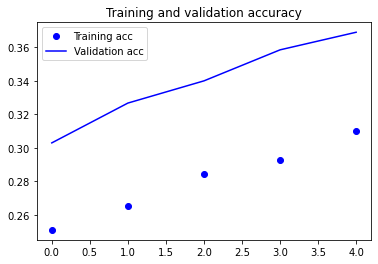

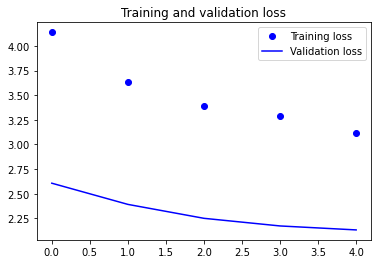

In [19]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
model.save("df2_model_effnet")

INFO:tensorflow:Assets written to: df2_model_effnet/assets
